In [86]:
import os
import csv
import librosa
import librosa.display
import torch
import numpy as np
from intervaltree import IntervalTree,Interval
import shutil
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.restoration import (denoise_wavelet, estimate_sigma)
import IPython.display as ipd

In [87]:
settings={}
settings['dataset']               ='podcastR2_mini'
settings['root_path']             = '/data/durgesh/orca206/orca_al'
#path to dataset folder
settings['data_source_path']      = os.path.join(settings['root_path'],'data_source',settings['dataset'])
settings['train_annotation']      = 'train.tsv'
settings['val_annotation']        = 'dev.tsv'
settings['test_annotation']       = 'test.tsv'
settings['mean_file']             = 'mean64.txt'
settings['invstd_file']           = 'invstd64.txt'
settings['media_folder']          = 'wav'

settings['train_media_path']      = os.path.join(settings['data_source_path'],'train_data',settings['media_folder'])
settings['train_anno_path']       = os.path.join(settings['data_source_path'],'train_data',settings['train_annotation'])
settings['val_anno_path']         = os.path.join(settings['data_source_path'],'train_data',settings['val_annotation'])
settings['mean_file_path']        = os.path.join(settings['data_source_path'],'train_data',settings['mean_file'])
settings['invstd_file_path']      = os.path.join(settings['data_source_path'],'train_data',settings['invstd_file'])

settings['samp_rate']             = 44100
settings['thr']                   = 0.1
settings['window_size']           = 2.45
settings['resample']              = True

### The code for this notebook is inspired from [Orca_CNN Pre-processing](https://github.com/axiom-data-science/OrcaCNN/tree/master/PreProcessing),[WAV_FLACprocessor_Val](https://github.com/orcasound/orcadata/tree/master/WAV_FLACprocessor_Val) and [NoiseReduce](https://pypi.org/project/noisereduce/). Thank you all the authors for writing these codes.

In [88]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data - min_data) / (max_data - min_data + 1e-6)
    return data - 0.5

def mfcc(S,n_mfcc=30):
    return librosa.feature.mfcc(S=S,n_mfcc=n_mfcc)

def spectrogram(data,n_fft= 2048,fftSize= 2048,overlap= -1,window='hann',center=True):

    if window == 'hann':
        win = librosa.filters.get_window('hann',fftSize)
    else:
        raise NotImplementedError
    
    if overlap == -1:
        jump = fftSize//4
    else:
        jump = int(fftSize*(100-overlap)/overlap)
    D = librosa.stft(data,center=center,window=win,win_length=fftSize,n_fft=n_fft,hop_length=jump)
    return D

def mel_spectrogram(D,pwr=2,sr=44100):
    if pwr == 2:
        D = np.abs(D)**2
    elif pwr == 1:
        D = np.abs(D)**1
    S = librosa.feature.melspectrogram(S=D,power=pwr,sr=sr)
    return S 

def reduce_bg_noise(y):
    import noisereduce as nr
    return nr.reduce_noise(audio_clip=y, noise_clip=y, verbose=False)

def amp(K):
    return librosa.amplitude_to_db(np.abs(K),ref=np.max(K))

def pwr(K):
    return librosa.power_to_db(np.abs(K),ref=np.max(K))

def pcen(D):
    return librosa.pcen(np.abs(D))

def wavelet_denoising(data):
    
    sigma_est = estimate_sigma(data, multichannel=True, average_sigmas=True)
    im_bayes = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='BayesShrink',
                               mode='soft')
    im_visushrink = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='VisuShrink',
                                    mode='soft')

    # VisuShrink is designed to eliminate noise with high probability, but this
    # results in a visually over-smooth appearance. Here, we specify a reduction
    # in the threshold by factors of 2 and 4.
    im_visushrink2 = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='VisuShrink',
                                     mode='soft', sigma=sigma_est / 2)
    im_visushrink4 = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='VisuShrink',
                                     mode='soft', sigma=sigma_est / 4)
    return im_bayes

def erode_and_dilate(img,kernel=np.ones((5,5), np.uint8)):
    img = img.copy()
    img = cv2.dilate(img, kernel, iterations=2) 
    img = cv2.erode(img, kernel, iterations=1)
    return img

def make_binary(img, Nsd=1):
    mean_time  = np.mean(img,axis=0,keepdims=True)
    std_time   = np.std(img,axis=0,keepdims=True)
    mean_freq  = np.mean(img,axis=-1,keepdims=True)
    std_freq   = np.std(img,axis=-1,keepdims=True)

    specBinary = np.zeros(img.shape)
    mask1 = np.logical_and(img >(mean_freq + Nsd*std_freq),img >(mean_time + Nsd*std_time))
    specBinary[mask1] = 1
    return specBinary

def contrast_enhance(img, Nsd=1):
    img    = img.copy()
    mean   = np.mean(img)
    std   = np.std(img)
    img[img>mean+Nsd*std] = mean+Nsd*std
    img[img<mean-Nsd*std] = mean-Nsd*std 
    return img

In [89]:
def get_intervals_dict_podcast_r2(labelfile):
    interval_dict = dict()
    with open(labelfile) as f:
        
        for i,(wav,start,dur,loc,date,data_source,data_source_id) in enumerate(csv.reader(f, delimiter='\t')):
            if i == 0 or float(dur)< settings['thr']: continue
            start = float(start)
            dur   = float(dur)
            end   = start+dur
            if wav not in interval_dict.keys():
                interval_dict[wav]=IntervalTree()
            interval_dict[wav].add(Interval(start,end))
    return interval_dict


def get_wavpaths():
    all_train_dev_wavs = glob.glob(os.path.join(settings['train_media_path'],'*'))
    train_interval_dict = get_intervals_dict_podcast_r2(settings['train_anno_path'])
    all_train_wavs  = []
    all_val_wavs    = []

    for wav_path in all_train_dev_wavs:
        wav_name = os.path.basename(wav_path)
        if wav_name in train_interval_dict:
            all_train_wavs.append(wav_path)
        else:
            all_val_wavs.append(wav_path)

    return all_train_wavs,all_val_wavs

class chunkaudio(object):
    
    def __init__(self,wav_path,interval_dict,window_size_t=2.5,target_sr=44100,pad_last=True,resample=True):
        
        self.wav_name = os.path.basename(wav_path)
        self.intervals = interval_dict[self.wav_name]
        self.orig_sr = librosa.get_samplerate(wav_path)
        self.target_sr = target_sr
        self.data, _= librosa.load(wav_path,self.orig_sr)
        self.window_size = int(window_size_t*self.orig_sr)
        excess = len(self.data)%self.window_size
        self.cum_stime =0
        self.curr_indx = 0
        self.win_no    = 0
        
        
        if excess and self.window_size < len(self.data) and pad_last:
            n_pad = self.window_size - excess
            self.data = np.pad(self.data,(0, n_pad),'reflect')
            
        if not resample:
            self.target_sr = self.orig_sr
            
    def __iter__(self):
        return self
            
    def __next__(self):
        data_chunk = self.data[self.curr_indx:self.curr_indx+self.window_size]
        chunk_stime = self.cum_stime
        chunk_etime = chunk_stime + len(data_chunk)/self.orig_sr
        
        if self.curr_indx >= len(self.data):
            raise StopIteration
            
        if self.intervals.overlaps(chunk_stime, chunk_etime):
            label = 1
        else:
            label = 0
        
        chunk_name = '_'.join([os.path.splitext(self.wav_name)[0],"%04d"%(self.win_no)])
            
        self.cum_stime = chunk_etime
        self.curr_indx = self.curr_indx+self.window_size
        self.win_no    +=1
        
        if self.target_sr != self.orig_sr:
            data_chunk = librosa.resample(data_chunk,self.orig_sr,self.target_sr)
        
        data_chunk     =   reduce_bg_noise(data_chunk)
        data_chunk     =  librosa.effects.preemphasis(data_chunk)
        return chunk_name,chunk_stime,chunk_etime,data_chunk,label

------------x-------Processing training data------x----------------
1562337136_0004_0000 0


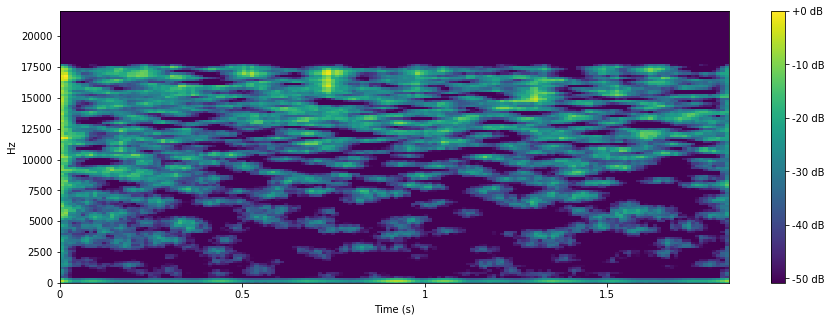

1562337136_0004_0001 0


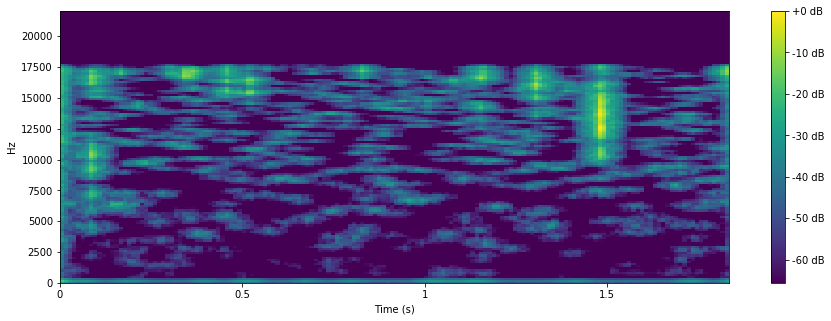

1562337136_0004_0002 0


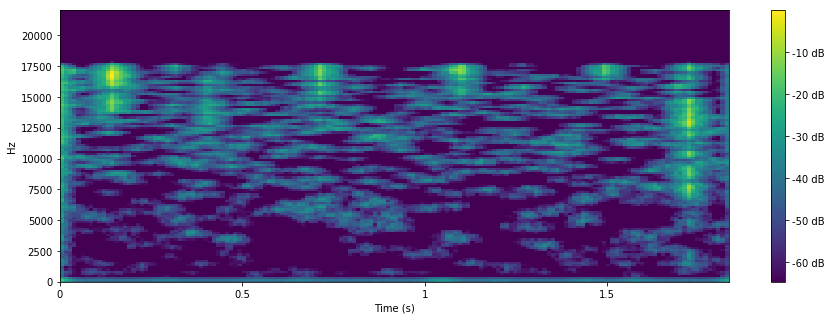

1562337136_0004_0003 0


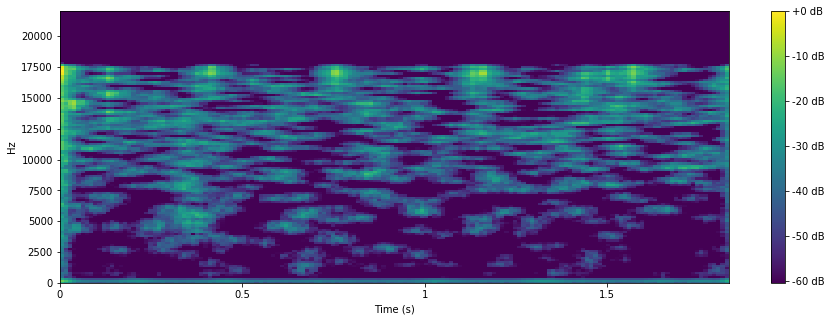

1562337136_0004_0004 0


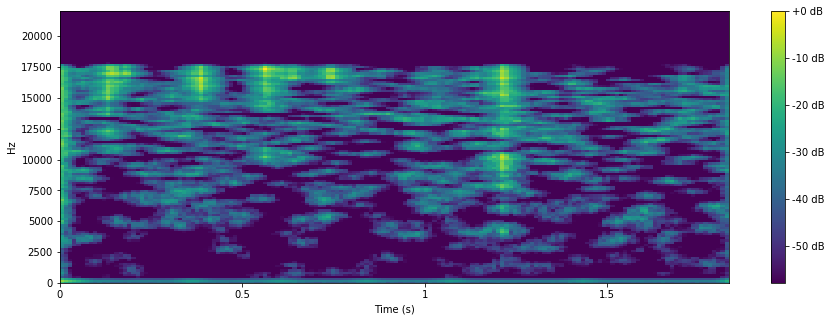

1562337136_0004_0005 0


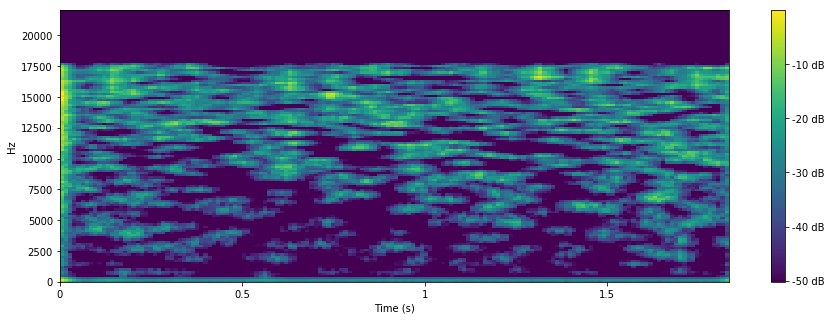

1562337136_0004_0006 0


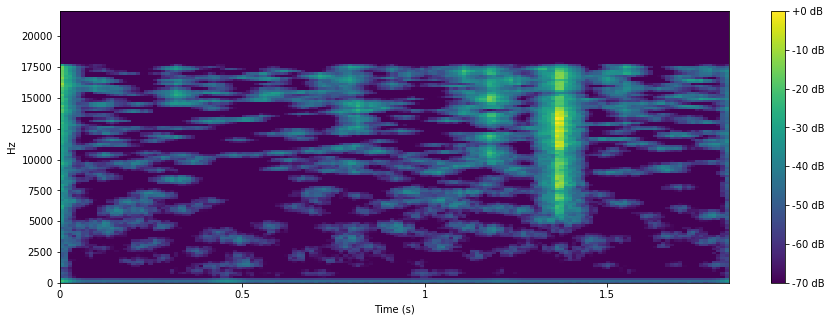

1562337136_0004_0007 0


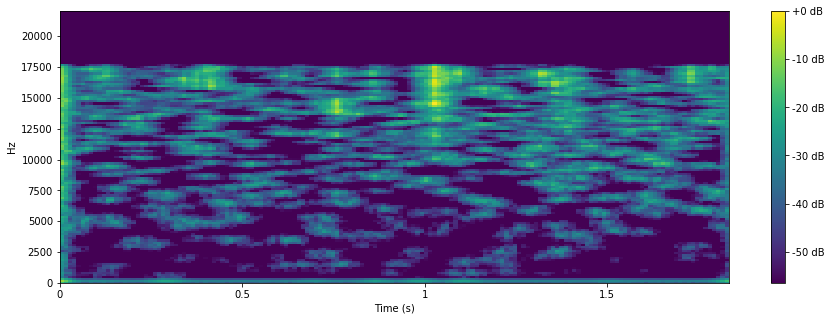

1562337136_0004_0008 0


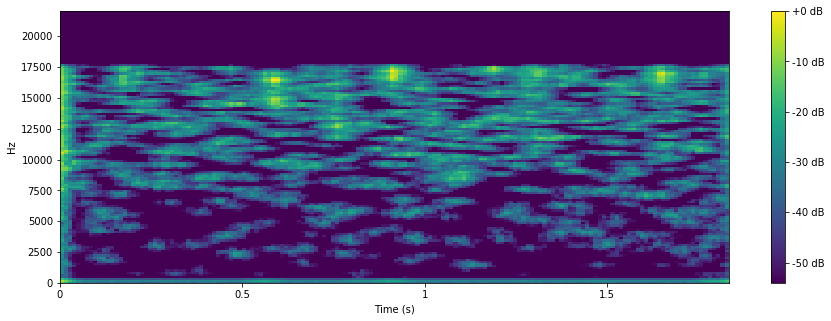

1562337136_0004_0009 0


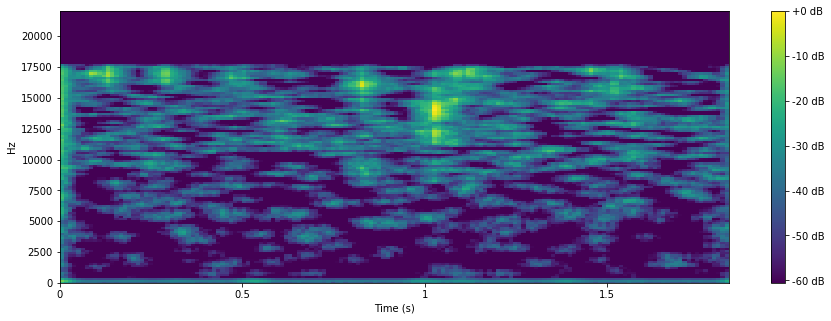

1562337136_0004_0010 0


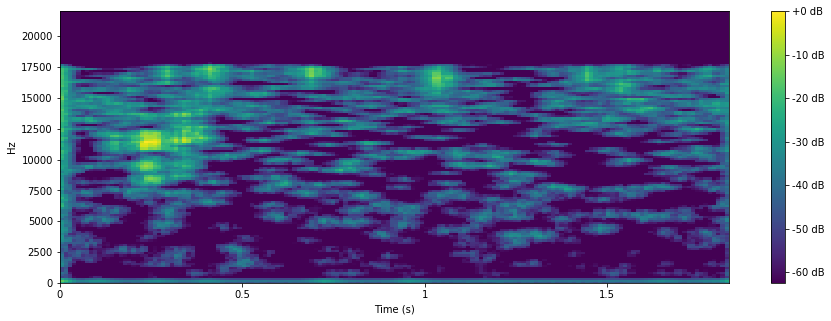

1562337136_0004_0011 0


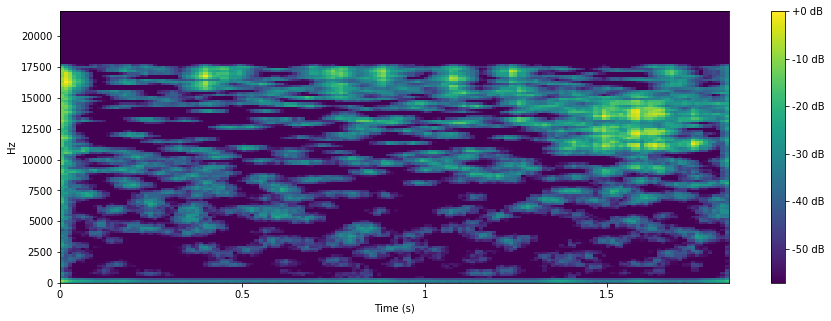

1562337136_0004_0012 0


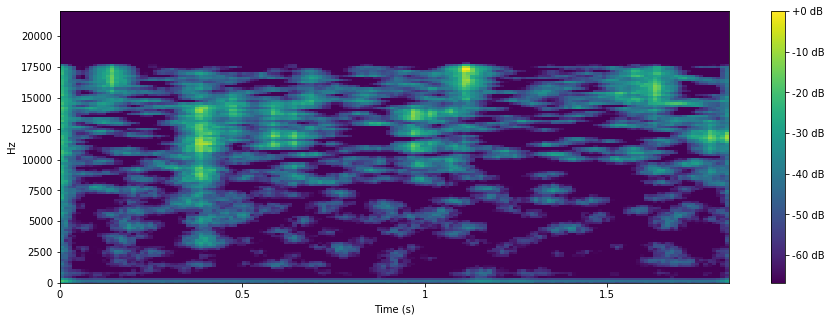

1562337136_0004_0013 0


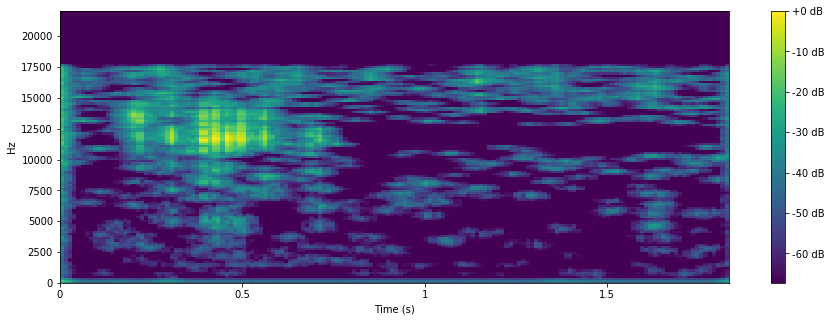

1562337136_0004_0014 1


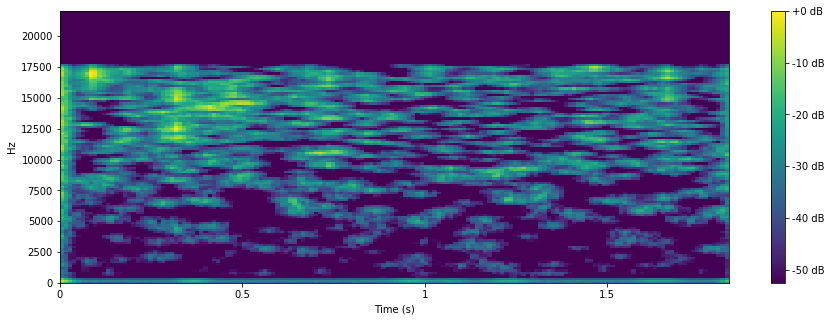

1562337136_0004_0015 1


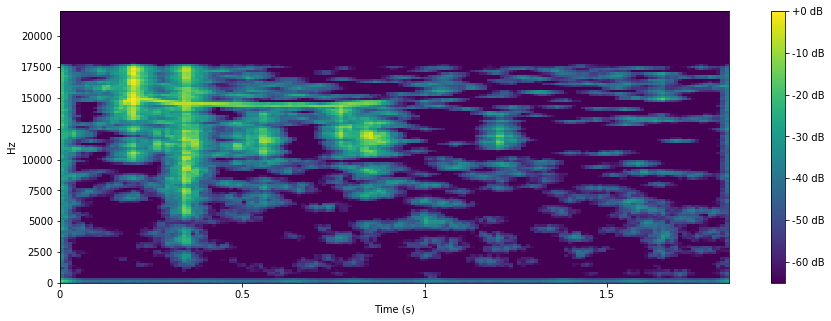

1562337136_0004_0016 1


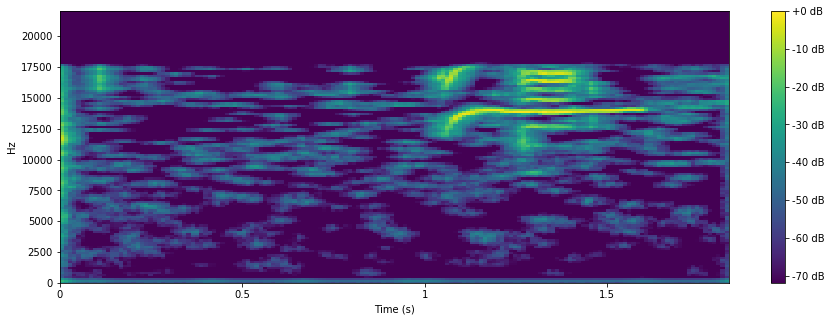

1562337136_0004_0017 1


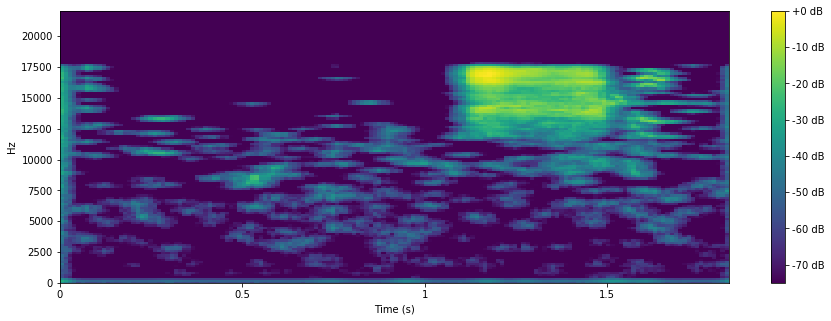

1562337136_0004_0018 1


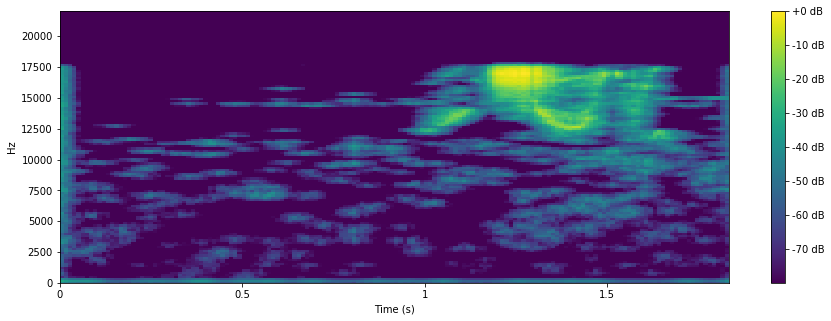

1562337136_0004_0019 1


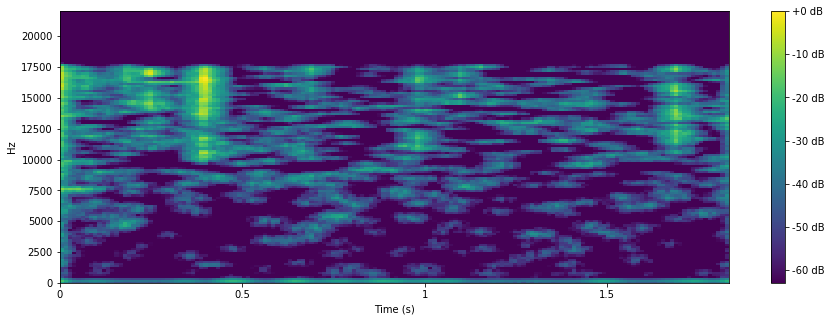

1562337136_0004_0020 1


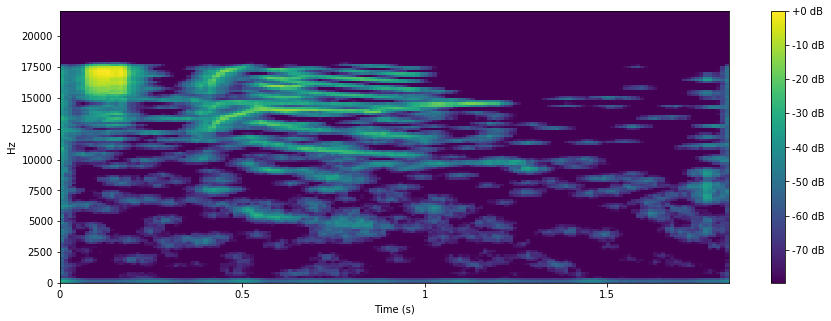

1562337136_0004_0021 1


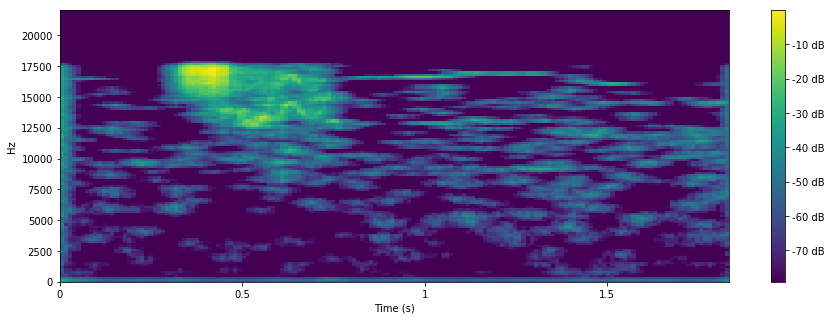

1562337136_0004_0022 1


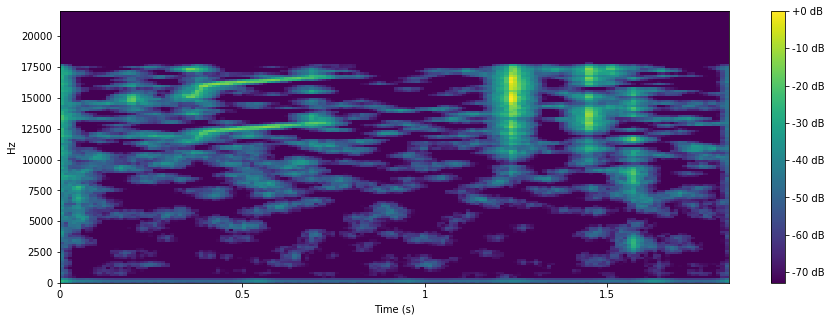

1562337136_0004_0023 0


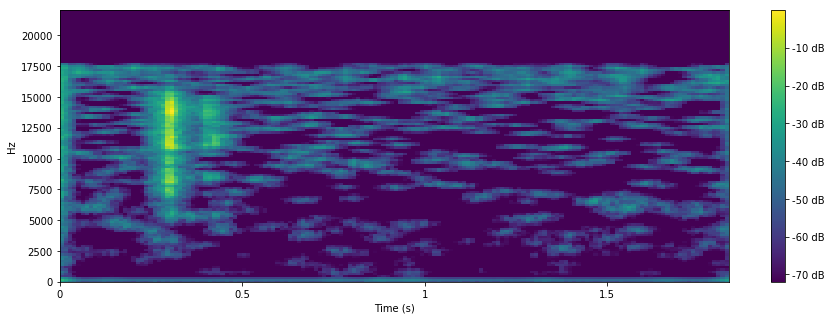

1562337136_0004_0024 0


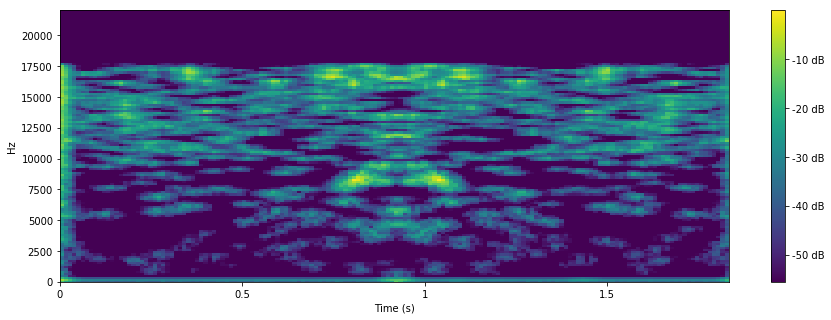

In [99]:
def process_data(wav_paths,window_size_t,interval_dict,target_sr,resample=True,pad_last=True):
    
    for wav_path in wav_paths:
        
        chk = chunkaudio(wav_path,interval_dict)
                
        for chunk_name,chunk_stime,chunk_etime,data_chunk,label in chk:
            print('{} {}'.format(chunk_name,label))
            #ipd.display(ipd.Audio(data_chunk,rate=target_sr))
            D      = spectrogram(data_chunk,center=False,overlap=75)
            S      = mel_spectrogram(D=D,sr=target_sr,pwr=1)
            S_amp   = amp(S)
            plt.figure(figsize=(15,5))
            _=librosa.display.specshow(S_amp,cmap='viridis',y_axis='linear',x_coords=np.arange(S_amp.shape[1])*512/target_sr,x_axis='s',sr=target_sr)
            _=plt.colorbar(format='%+2.0f dB')
            plt.show()
    
train_interval_dict = get_intervals_dict_podcast_r2(settings['train_anno_path'])
val_interval_dict = get_intervals_dict_podcast_r2(settings['val_anno_path'])


all_train_wavs,all_val_wavs = get_wavpaths()
print('------------x-------Processing training data------x----------------')
process_data(all_train_wavs,settings['window_size'],train_interval_dict,settings['samp_rate'])

------------x-------Processing dev data------x----------------
1562337136_0005_0000 1


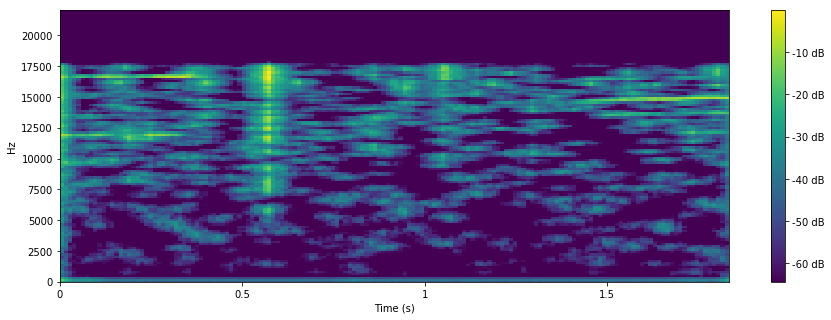

1562337136_0005_0001 1


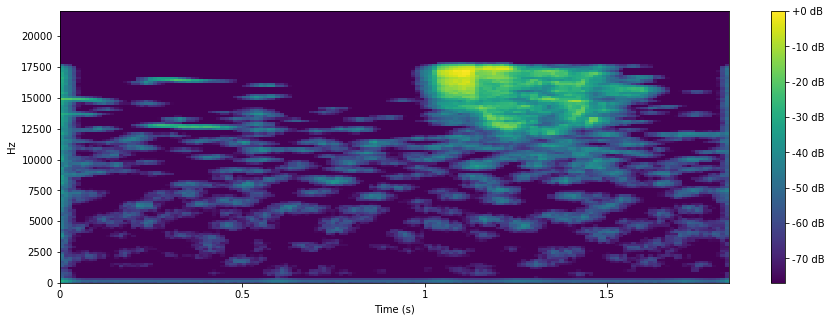

1562337136_0005_0002 1


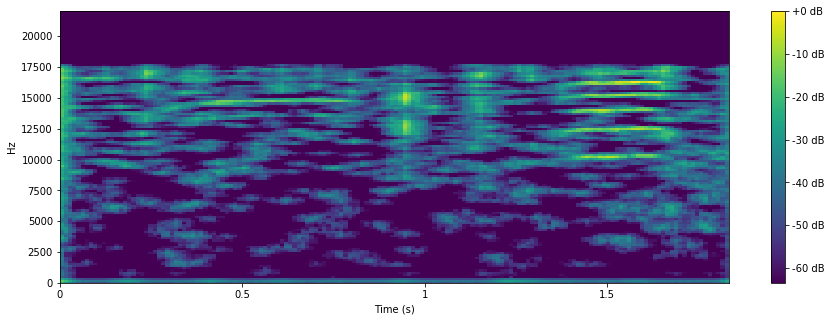

1562337136_0005_0003 1


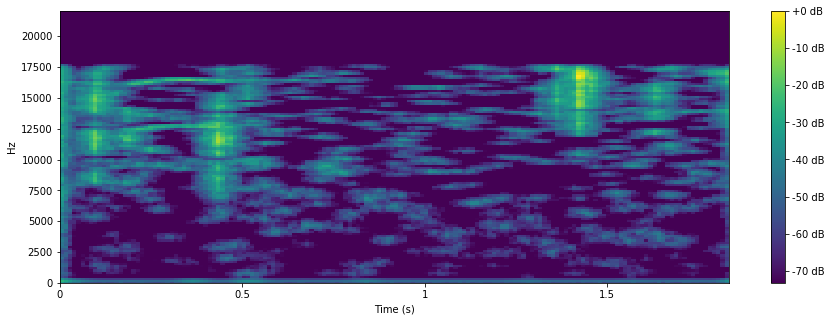

1562337136_0005_0004 1


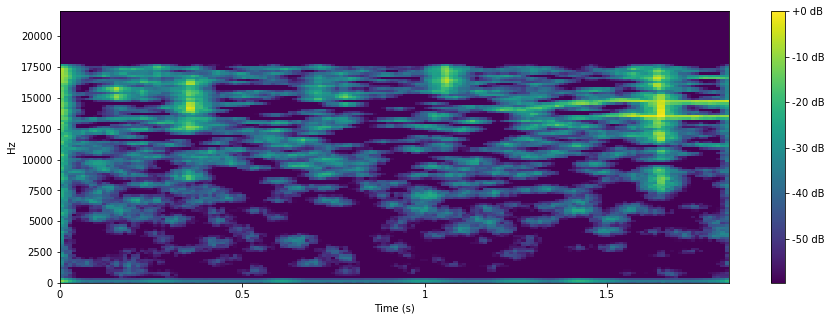

1562337136_0005_0005 1


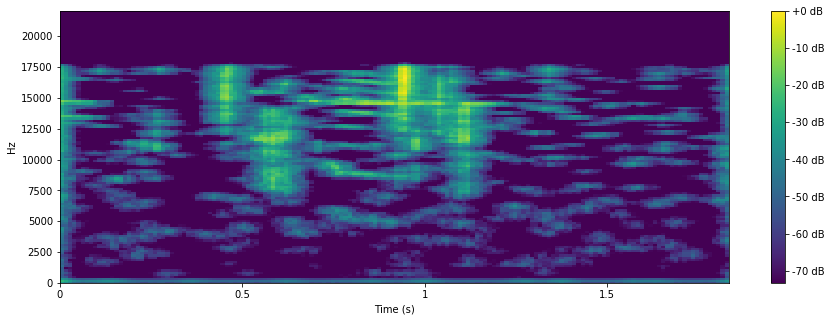

1562337136_0005_0006 1


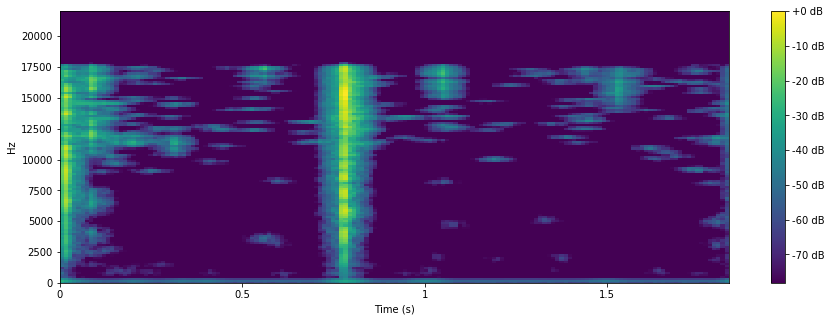

1562337136_0005_0007 1


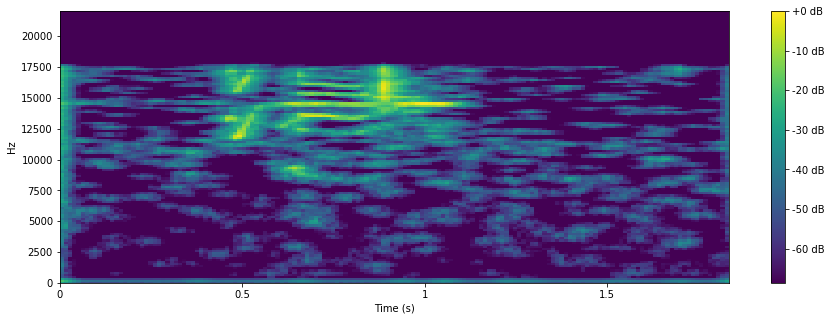

1562337136_0005_0008 1


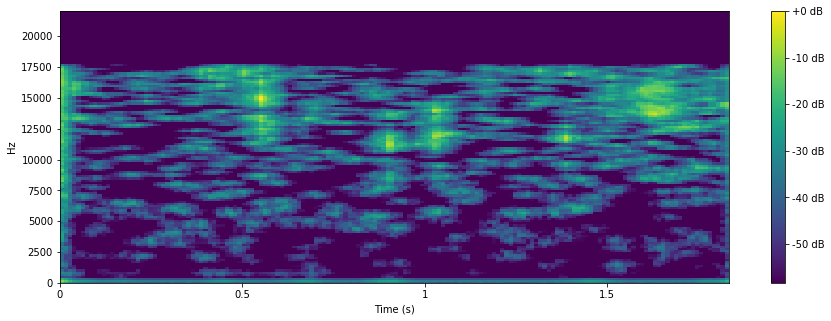

1562337136_0005_0009 1


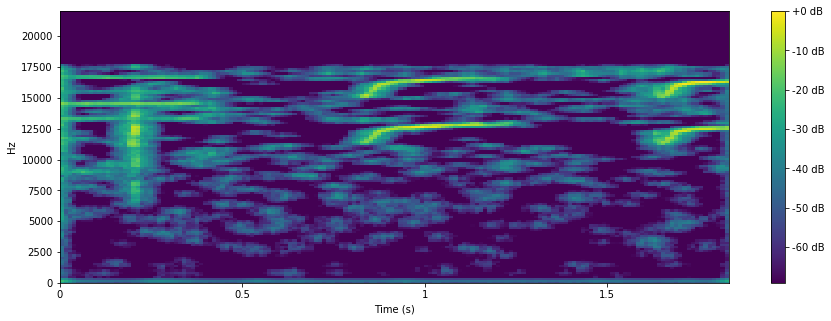

1562337136_0005_0010 1


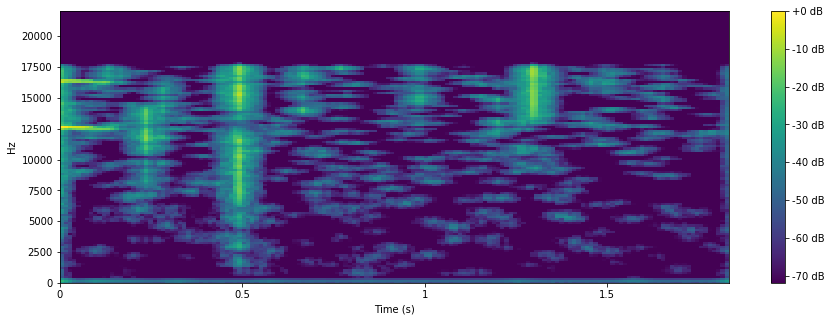

1562337136_0005_0011 1


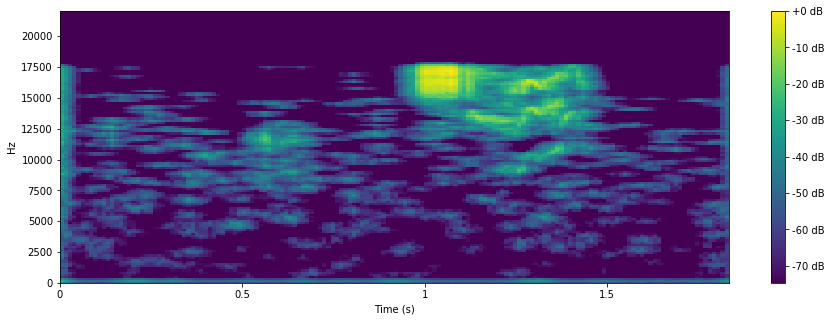

1562337136_0005_0012 1


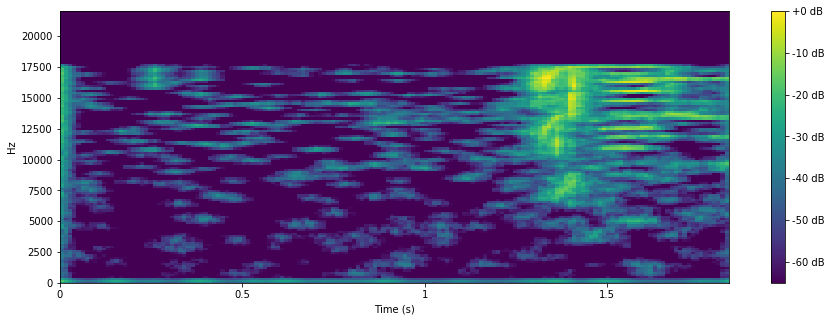

1562337136_0005_0013 1


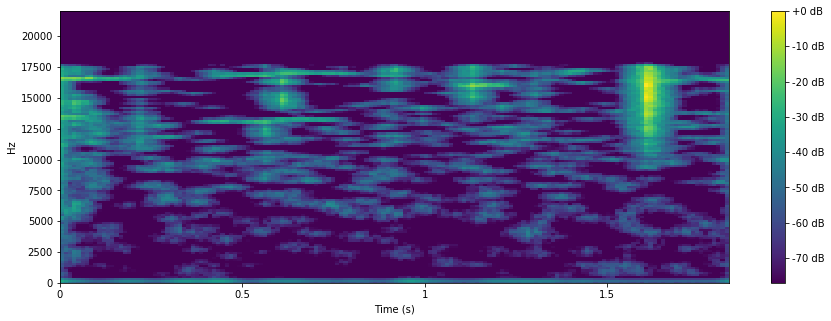

1562337136_0005_0014 1


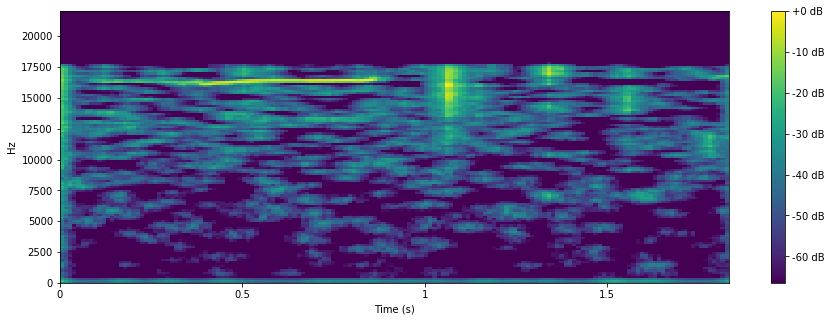

1562337136_0005_0015 1


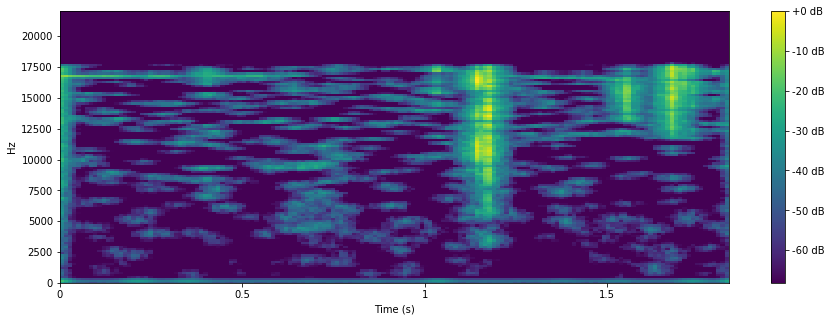

1562337136_0005_0016 1


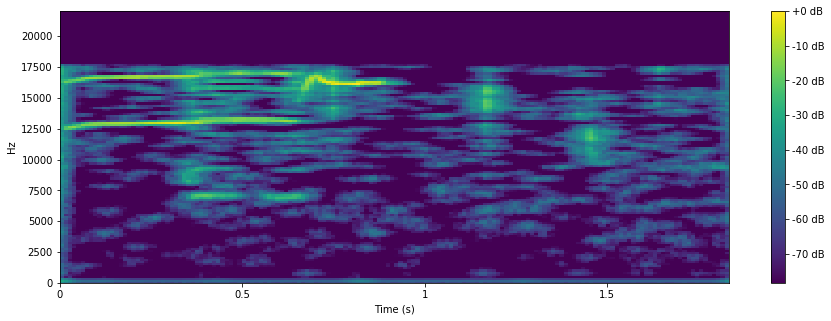

1562337136_0005_0017 1


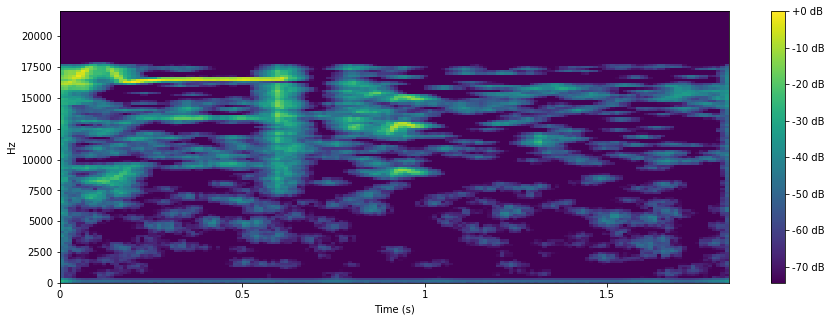

1562337136_0005_0018 1


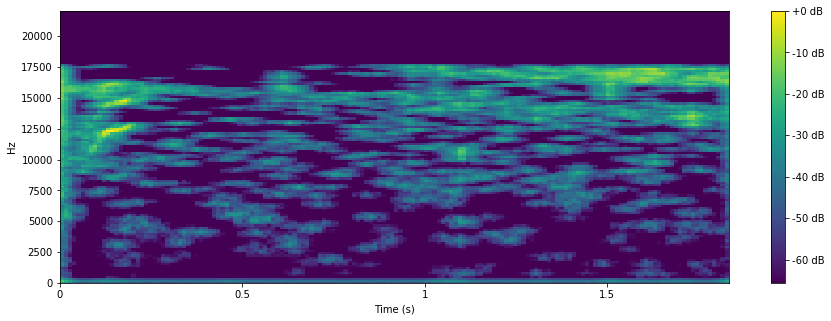

1562337136_0005_0019 1


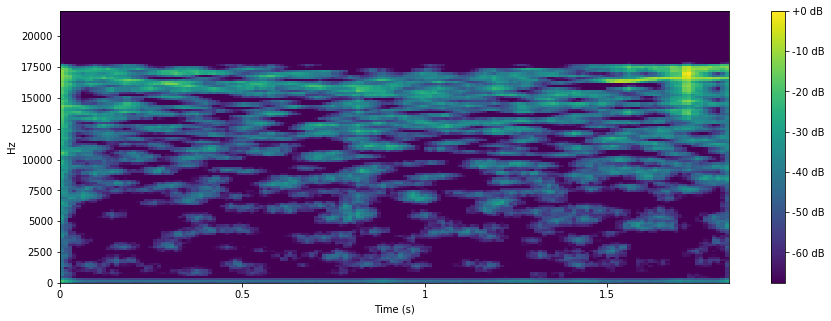

1562337136_0005_0020 1


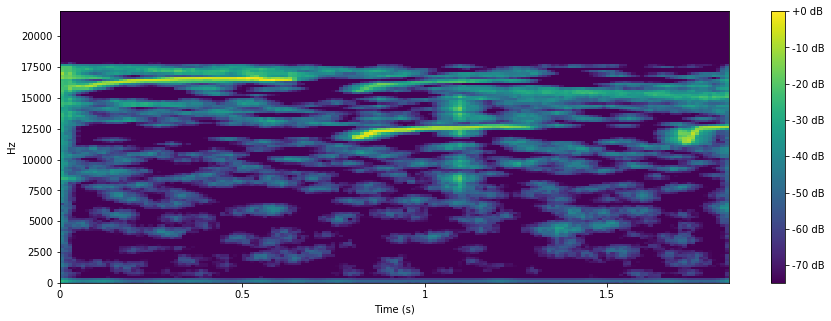

1562337136_0005_0021 1


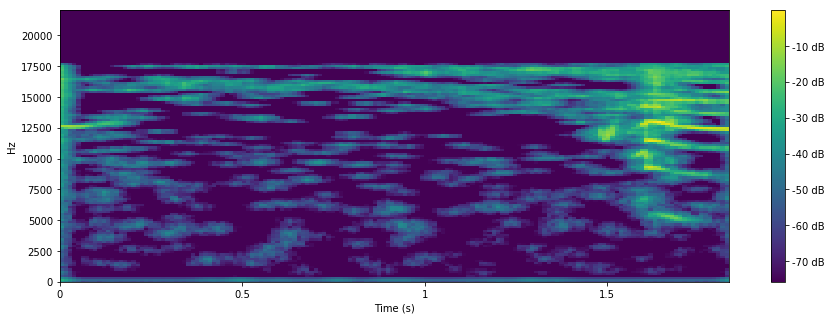

1562337136_0005_0022 1


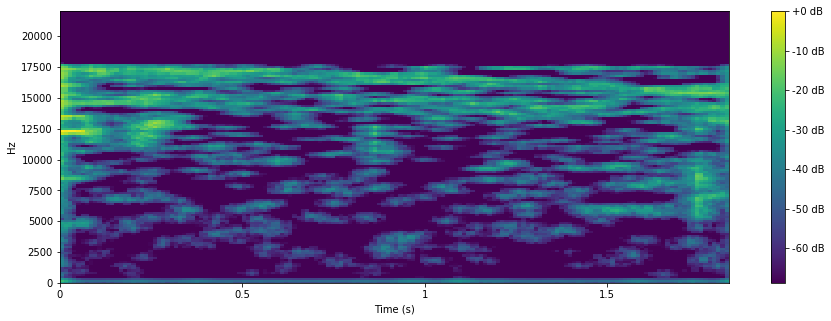

1562337136_0005_0023 1


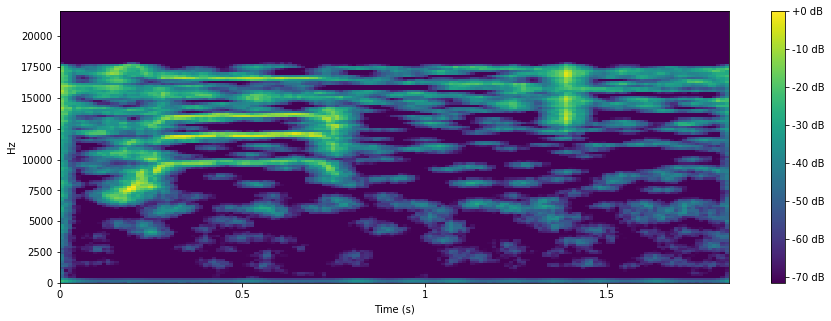

1562337136_0005_0024 0


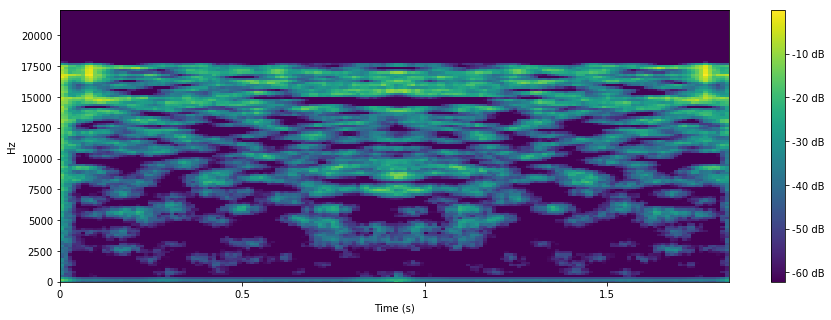

In [100]:
print('------------x-------Processing dev data------x----------------')
process_data(all_val_wavs,settings['window_size'],val_interval_dict,settings['samp_rate'])